In [1]:
import numpy as np
from scipy import stats
from scipy import constants
import matplotlib.pyplot as plt
from rich.progress import Progress
from scipy.stats import binned_statistic
from utils.plot_utils import set_fontsize

In [2]:
def doppler_shift(f,v):
    return f*(1+v/constants.c)

def rotation(θ):
    return np.array([[np.cos(θ), -np.sin(θ)], [np.sin(θ), np.cos(θ)]])

In [3]:
f0 = 1.103e15 # Hz of transition
vcm = 184 # m/s
σvcm = 16.8 # m/s
σvt = 1.1 # m/s, estimate from simulation with apertures

In [4]:
generate_random_longitudinal_velocities = lambda x: np.random.normal(vcm, σvcm, x)

def generate_random_transverse_velocities(size):
    v_transverse = np.random.multivariate_normal([0,0],np.array([[σvt**2,0],[0,σvt**2]]),size).T
    return v_transverse

In [5]:
size = 100_000

In [6]:
v_z = generate_random_longitudinal_velocities(size)
v_x, v_y = generate_random_transverse_velocities(size)

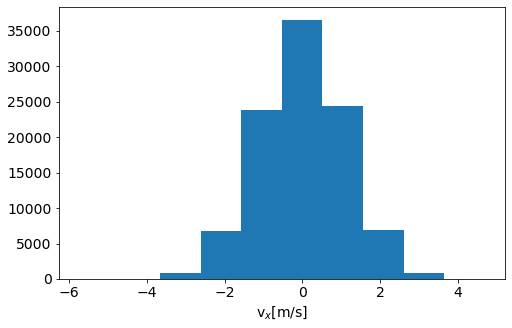

In [7]:
fig, ax = plt.subplots(figsize = (8,5))
ax.hist(v_x)

ax.set_xlabel(r'v$_{x}$[m/s]')

set_fontsize(ax, 14)

In [8]:
α_laser = 5 # angle in degrees between laser and molecular beam
R = rotation(np.deg2rad(-α_laser))

In [9]:
v_tcm = np.sin(np.deg2rad(α_laser))*v_z
v_tt = np.cos(np.deg2rad(α_laser))*v_x

v_perp = 16.03 +/- 1.83


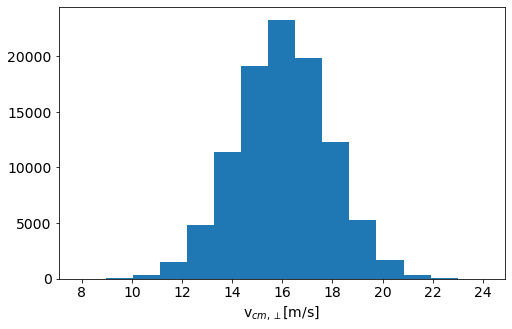

In [10]:
v_perpendicular = R@np.array([v_x, v_z])

fig, ax = plt.subplots(figsize = (8,5))
ax.hist(v_perpendicular[0], bins = 15)

ax.set_xlabel(r'v$_{cm,\perp}$[m/s]')

set_fontsize(ax, 14)

print(f"v_perp = {np.mean(v_perpendicular[0]):.2f} +/- {np.std(v_perpendicular[0]):.2f}")

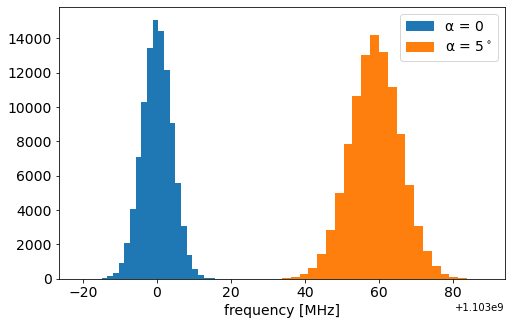

In [11]:
distribution_aligned = doppler_shift(f0,v_x)
distribution_angled = doppler_shift(f0, v_perpendicular[0])

fig, ax = plt.subplots(figsize = (8,5))
ax.hist(distribution_aligned/1e6, bins = 25, label = 'α = 0')
ax.hist(distribution_angled/1e6, bins = 25, label = r'α = 5$^\circ$')

ax.set_xlabel('frequency [MHz]')
ax.legend(fontsize = 14)

set_fontsize(ax, 14)

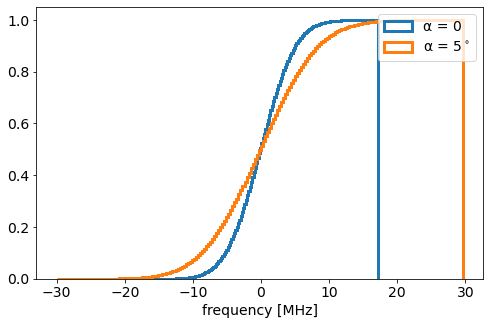

In [12]:
norm_aligned = distribution_aligned - np.mean(distribution_aligned)
norm_angled = distribution_angled - np.mean(distribution_angled)

fig, ax = plt.subplots(figsize = (8,5))
ax.hist(norm_aligned/1e6, bins = 201, label = 'α = 0', histtype = 'step', cumulative = True, lw = 3, density = True)
ax.hist(norm_angled/1e6, bins = 201, label = r'α = 5$^\circ$', histtype = 'step', cumulative = True, lw = 3, density = True)

ax.set_xlabel('frequency [MHz]')
ax.legend(fontsize = 14)

set_fontsize(ax, 14)

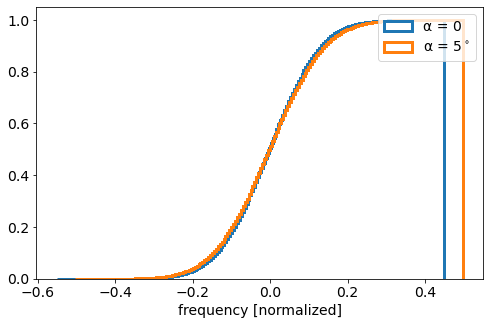

In [13]:
norm_aligned = distribution_aligned/np.ptp(distribution_aligned)
norm_aligned -= np.mean(norm_aligned)
norm_angled = distribution_angled/np.ptp(distribution_angled)
norm_angled -= np.mean(norm_angled)


fig, ax = plt.subplots(figsize = (8,5))
ax.hist(norm_aligned, bins = 201, label = 'α = 0', histtype = 'step', cumulative = True, lw = 3, density = True)
ax.hist(norm_angled, bins = 201, label = r'α = 5$^\circ$', histtype = 'step', cumulative = True, lw = 3, density = True)

ax.set_xlabel('frequency [normalized]')
ax.legend(fontsize = 14)

set_fontsize(ax, 14)

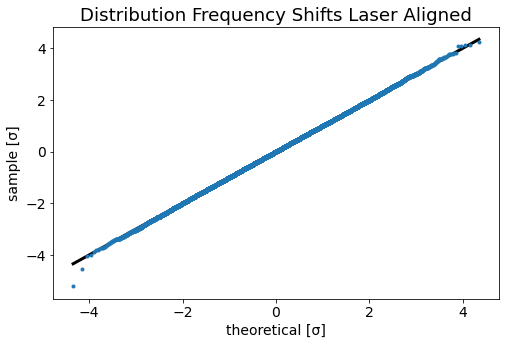

In [14]:
ffunc = lambda x, a, b: a*x+b

(osm, osr), (fit_params) = stats.probplot(distribution_aligned, dist = 'norm', fit = True)
_x = np.linspace(osm.min(), osm.max(), 101)

μ = np.mean(osr)
σ = np.std(osr)

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(_x, (ffunc(_x, *fit_params[:2]) - μ)/σ, 'k', lw = 3)
ax.plot(osm, (osr-μ)/σ, '.')

ax.set_title('Distribution Frequency Shifts Laser Aligned')
ax.set_xlabel('theoretical [σ]')
ax.set_ylabel('sample [σ]')

set_fontsize(ax, 14)

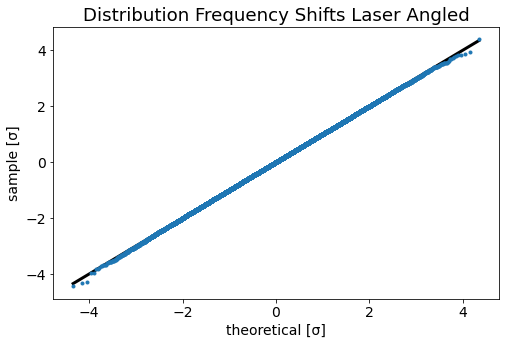

In [15]:
ffunc = lambda x, a, b: a*x+b

(osm, osr), (fit_params) = stats.probplot(distribution_angled, dist = 'norm', fit = True)
_x = np.linspace(osm.min(), osm.max(), 101)

μ = np.mean(osr)
σ = np.std(osr)

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(_x, (ffunc(_x, *fit_params[:2]) - μ)/σ, 'k', lw = 3)
ax.plot(osm, (osr-μ)/σ, '.')

ax.set_title('Distribution Frequency Shifts Laser Angled')
ax.set_xlabel('theoretical [σ]')
ax.set_ylabel('sample [σ]')

set_fontsize(ax, 14)

## Frequency broadening

$\Delta f = \sqrt{(\sin{\alpha} v_{cm})^2 + (\cos{\alpha} v_\perp)^2} \frac{f_0}{c}$

In [16]:
def frequency_broadening(α, f0, v_cm, v_t):
    return np.sqrt( (np.sin(α)*v_cm) **2 + (np.cos(α) * v_t)**2 ) * f0/constants.c

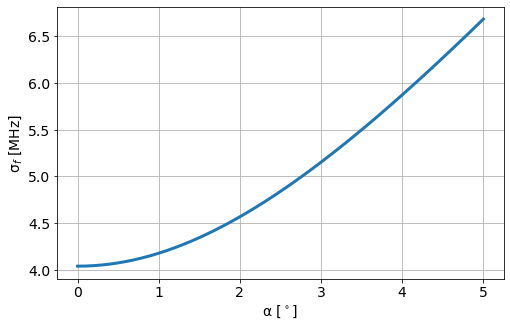

In [31]:
_α = np.linspace(0,5,201)
f0 = 1.1e15 # Hz

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(_α, frequency_broadening(np.deg2rad(_α), f0, 16.7, 1.1)/1e6, lw = 3)

ax.set_xlabel('α [$^\circ$]')
ax.set_ylabel('σ$_f$ [MHz]')

ax.grid(True)

set_fontsize(ax, 14)

In [51]:
max_xoffset = 1.75 * 2.54 / 100 # molecular beam cannot be offset by more than the window diameter [m]
beam_len = 2 # m

print(f"{np.rad2deg(np.arctan(max_xoffset/beam_len)):.2f} degrees max estimated beam offset")

1.27 degrees max estimated beam offset


In [50]:
# laser offset if going from one side of the window to the other side across the vacuum chamber ->
# |---      |
# |   ---   |
# |      ---|
print(f"{np.rad2deg(np.arctan(max_xoffset/1)):.2f} degrees max estimated laser offset")

2.55 degrees max estimated laser offset
